In [2]:
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm
%matplotlib inline

In [3]:
stock_name = 'AAPL'
data = pd.read_csv('StockData/{}.csv'.format(stock_name))

In [4]:
del data["Volume"]

<AxesSubplot:>

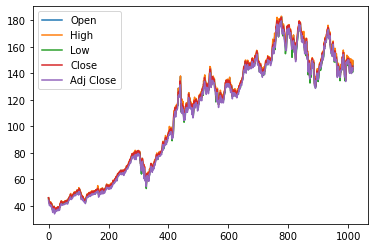

In [5]:
data.plot()

<AxesSubplot:>

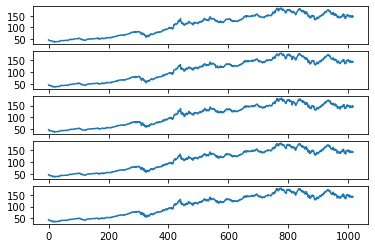

In [6]:
plt.subplot(5,1,1)
data["High"].plot()
plt.subplot(5,1,2)
data["Low"].plot()
plt.subplot(5,1,3)
data["Open"].plot()
plt.subplot(5,1,4)
data["Close"].plot()
plt.subplot(5,1,5)
data["Adj Close"].plot()

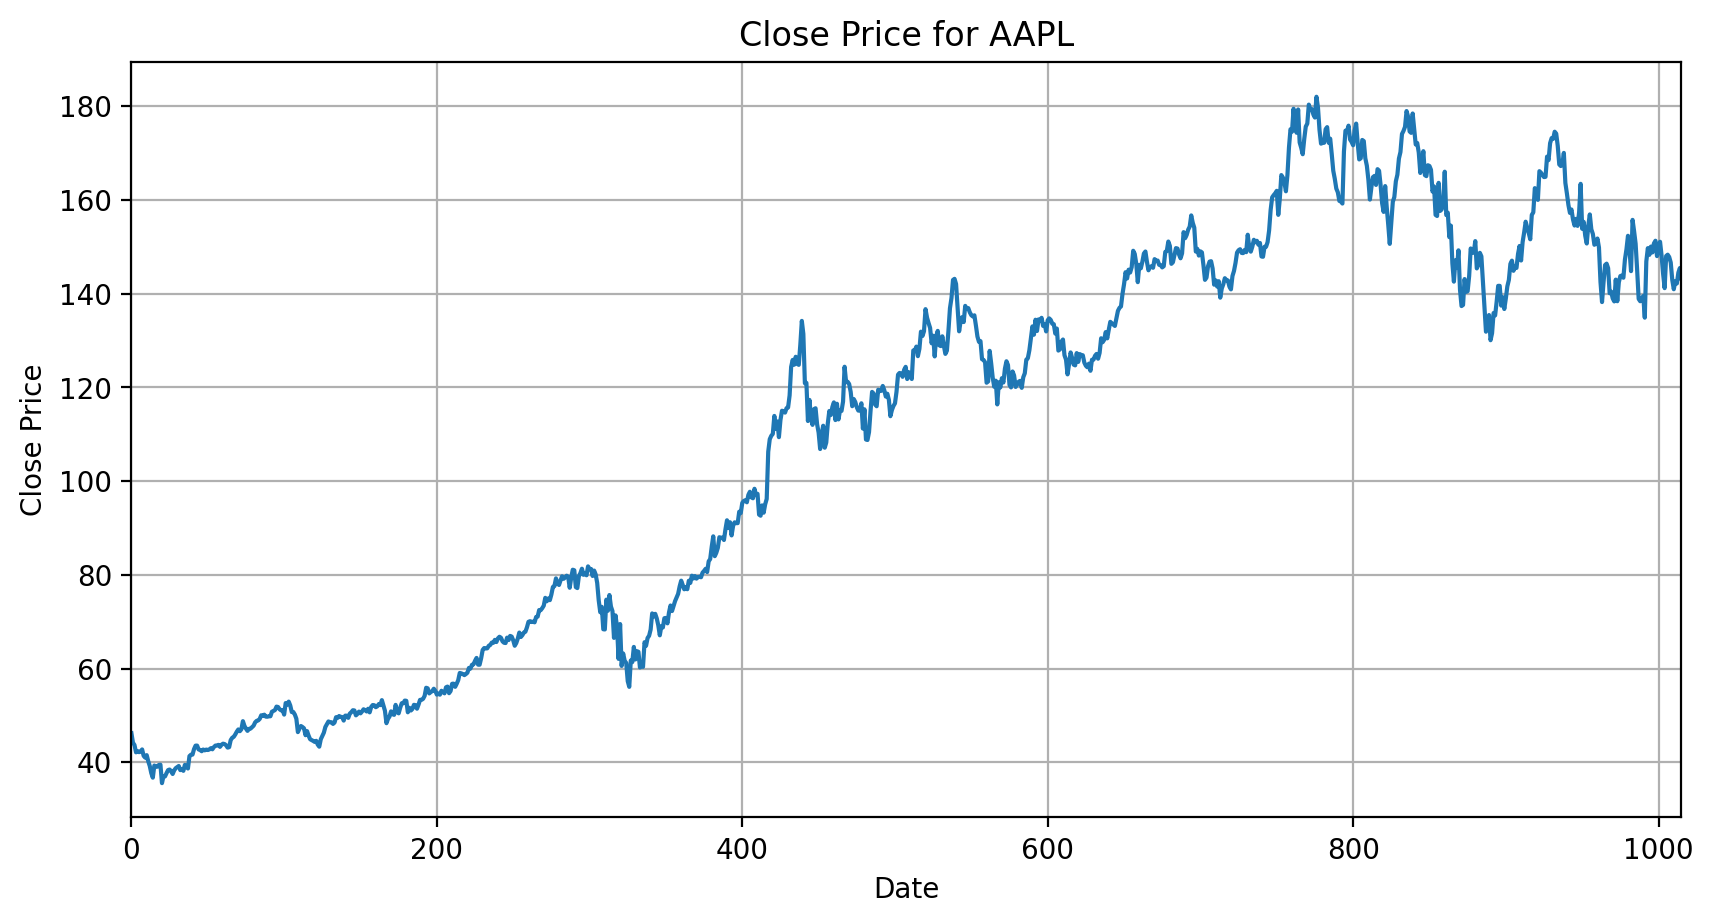

In [8]:
plt.rcParams["figure.dpi"]=200
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Close Price for {}'.format(stock_name))
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data["Close"])

In [9]:
all_data=data["Close"].values.astype(float)[-500:]   #只用收盘价

train_size=0.8       #训练集比例
data_size=len(all_data)    #数据集大小

train_data,test_data = all_data[:int(train_size*data_size)],all_data[int(train_size*data_size):]   #划分训练集和验证集


print(len(train_data))
print(len(test_data))

400
100


In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized.shape

torch.Size([400])

In [11]:
train_window = 5
stride=1
def create_inout_sequences(input_data, tw,stride):     #形成训练集和标签
    inout_seq = []
    L = len(input_data)
    for i in range(0,L-tw,stride):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window,stride)
print(len(train_inout_seq))

395


In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=150, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size)) # (num_layers * num_directions, batch_size, hidden_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

开始训练


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]

epoch:  49 loss: 0.0000668673
结束训练,共耗时:28.79sec


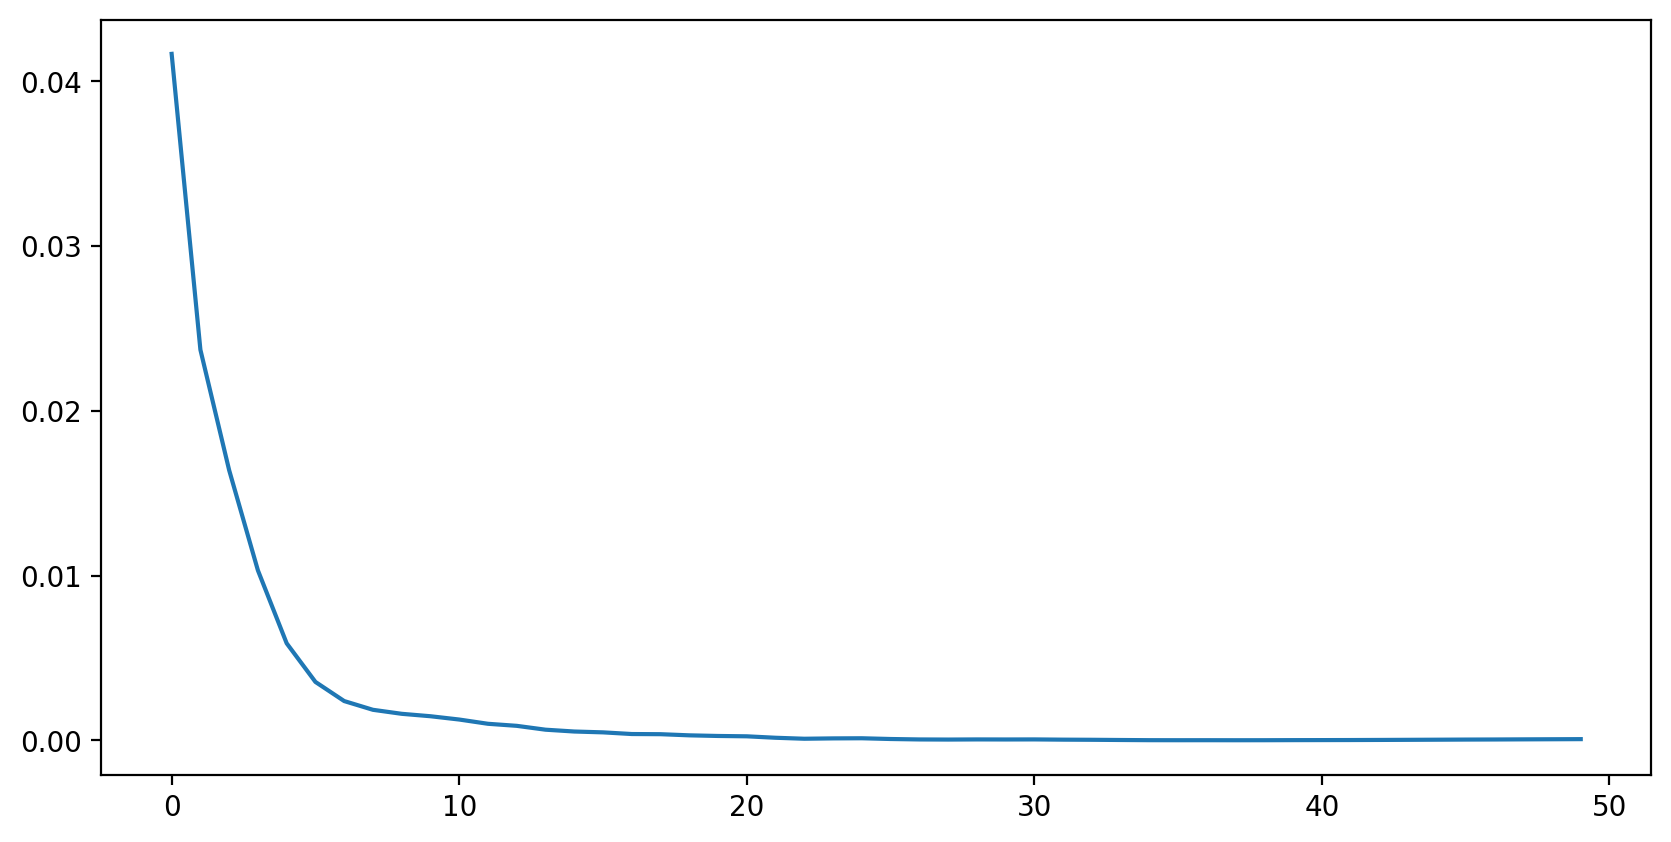

In [13]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
start_time=time.time()
print("开始训练")

Loss=[]
for i in tqdm(range(epochs)):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    Loss.append(single_loss.item())
    # if i%25 == 0:
    #     print(f'epoch: {i:3}|{epochs} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
total_time=time.time()-start_time

print(f"结束训练,共耗时:{round(total_time,2)}sec")
plt.plot(Loss)

误差为： 4.254082049927441
相对误差率：3.35%


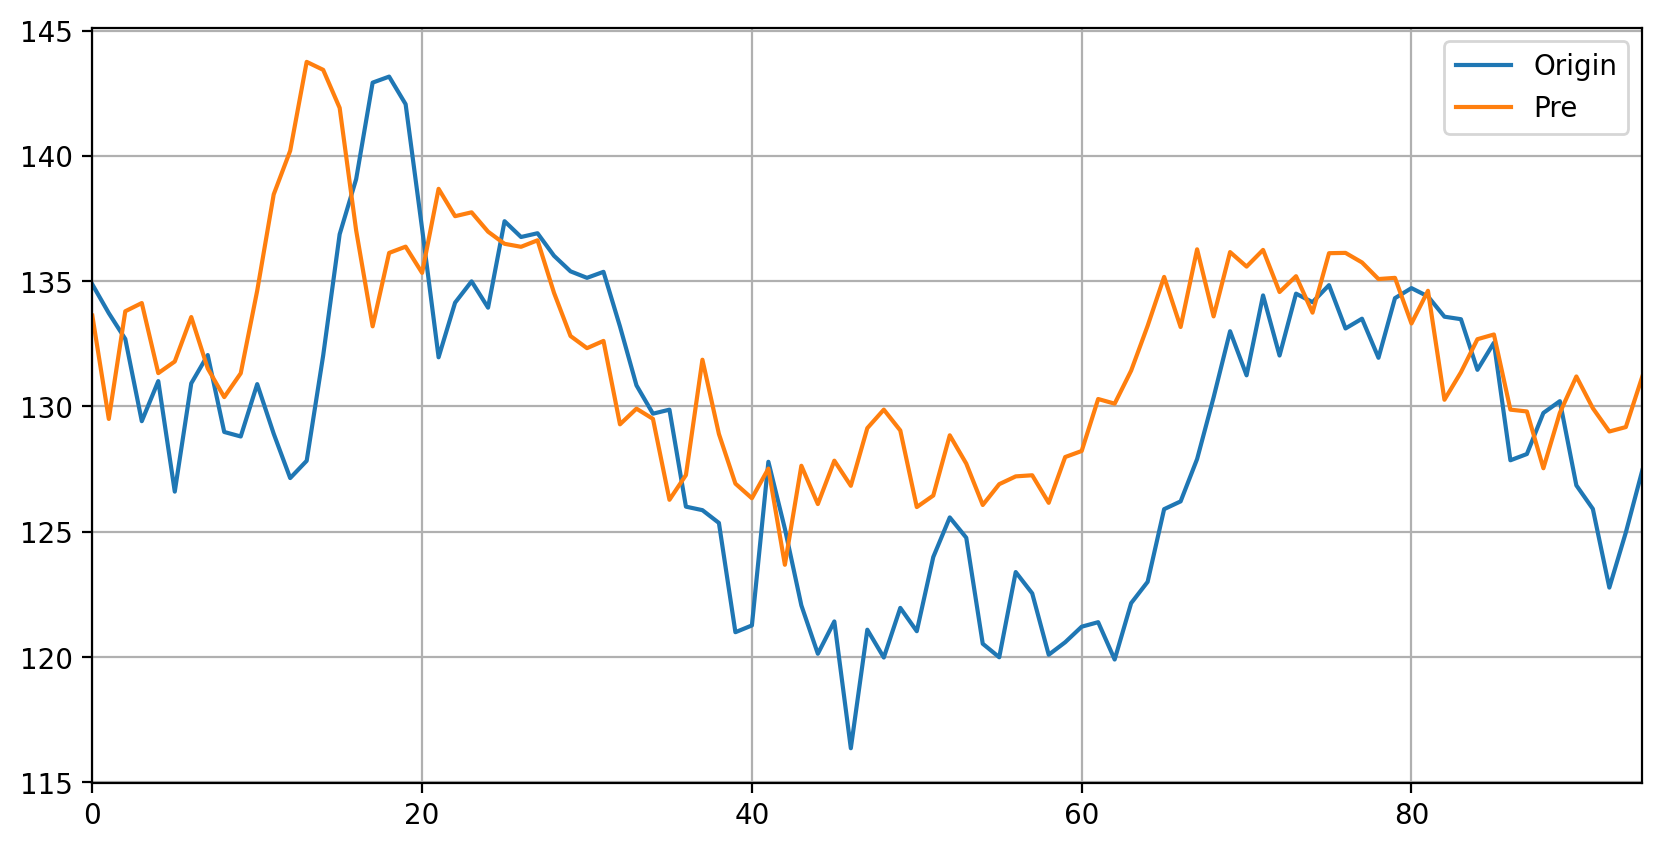

In [14]:
fut_pred = 100    #预测的个数

test_inputs =[]

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+train_window])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())                            #将预测值加入序列

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))   #变换回去

error=np.sum(np.abs(actual_predictions.flatten()-train_data[train_window:fut_pred]))/len(actual_predictions)
error_rate=np.sum(np.abs(actual_predictions.flatten()-train_data[train_window:fut_pred])/np.abs(train_data[train_window:fut_pred]))/len(actual_predictions)
print("误差为：",error)
print("相对误差率：{:.2f}%".format(error_rate*100))

plt.rcParams["figure.dpi"]=200
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(train_data[train_window:fut_pred],label="Origin")
plt.plot(actual_predictions,label="Pre")
plt.legend()
plt.show()


In [53]:
np.abs(actual_predictions.flatten()-train_data[train_window:fut_pred]).shape

(195,)

# 预测

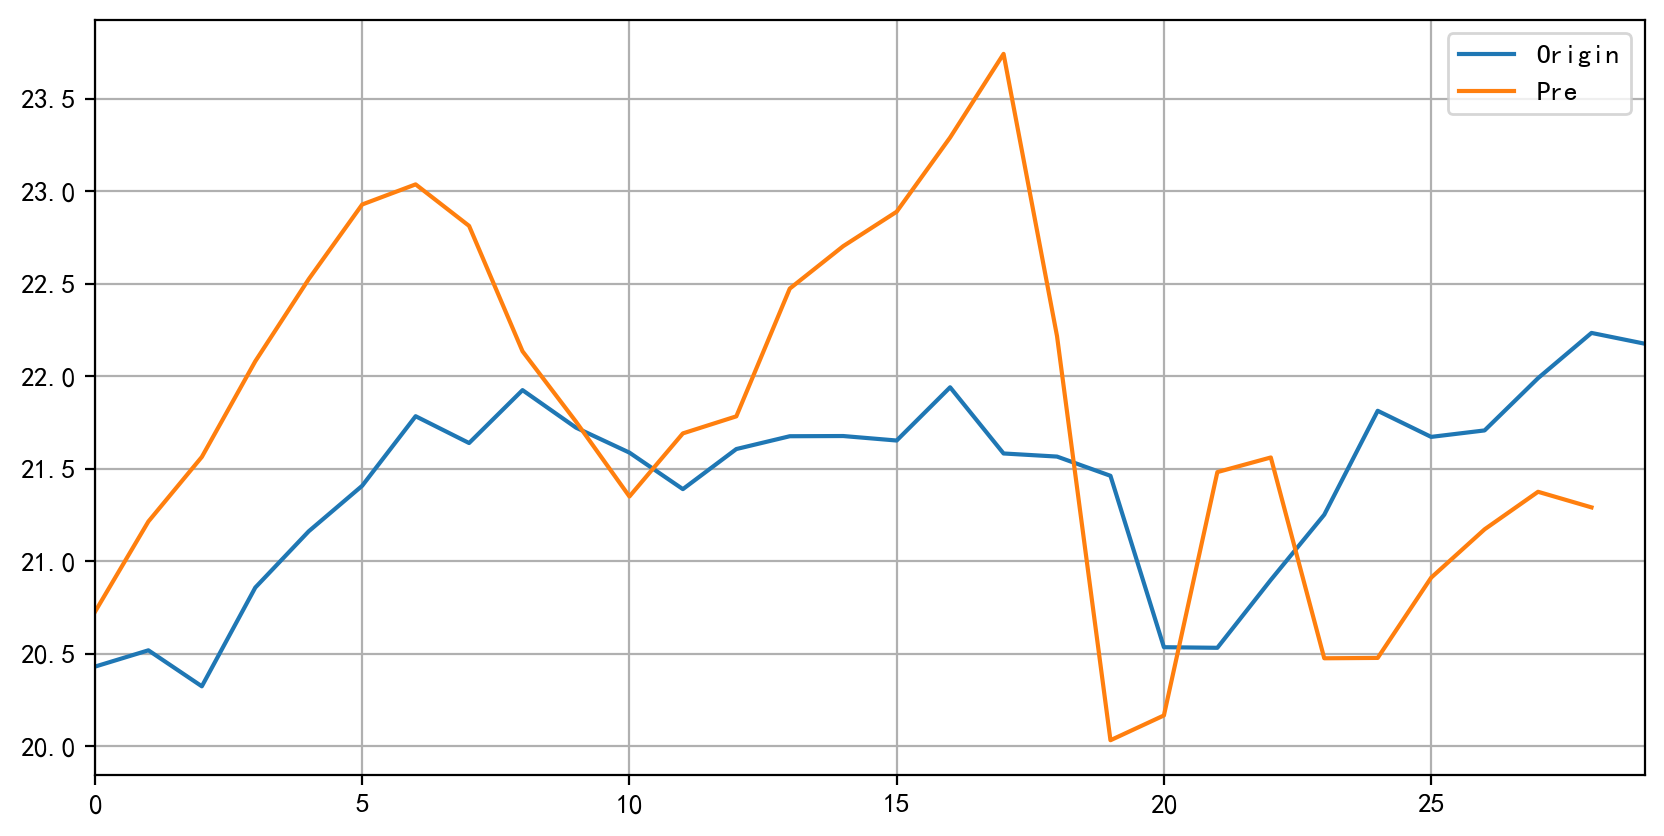

In [34]:
fut_pred = 30    #预测的个数

test_inputs = train_data_normalized[-train_window:].tolist()   #从训练数据结尾开始预测

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())                            #将预测值加入序列

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window+1:] ).reshape(-1, 1))   #变换回去

plt.rcParams["figure.dpi"]=200
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(test_data[:fut_pred],label="Origin")
plt.plot(actual_predictions,label="Pre")
#plt.ylim(0,30)
plt.legend()
plt.show()
